In [1]:
#imports
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from scipy.ndimage import gaussian_filter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [127]:
def ifft2c(tensor, dim=(-2, -1)):
    tensor = torch.fft.ifftshift(tensor, dim=dim)
    tensor = torch.fft.ifft2(tensor, dim=dim)
    return torch.fft.fftshift(tensor, dim=dim)
def complex2channels(image, dim=0):
    """Convert single from complex to channels"""
    return torch.cat((image.real, image.imag), dim=dim).float()


data dir /mikQNAP/NYU_knee_data/knee_train_h5/data/train
Using data from: /mikQNAP/NYU_knee_data/knee_train_h5/data/train
Found 5120 image paths.


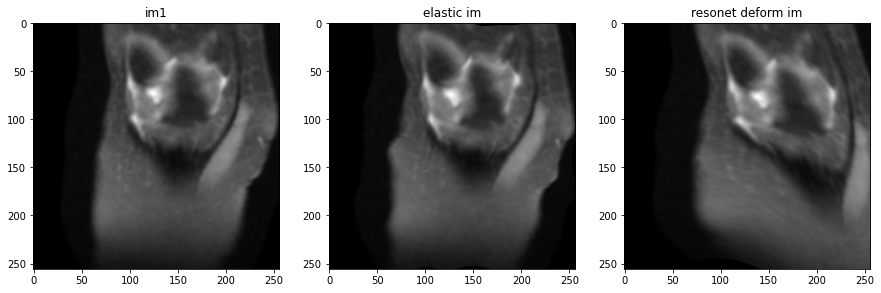

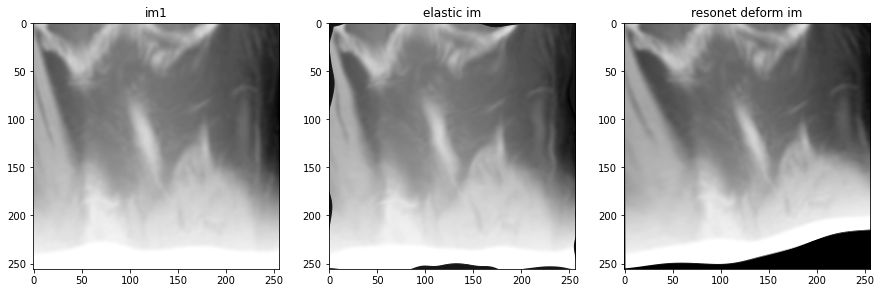

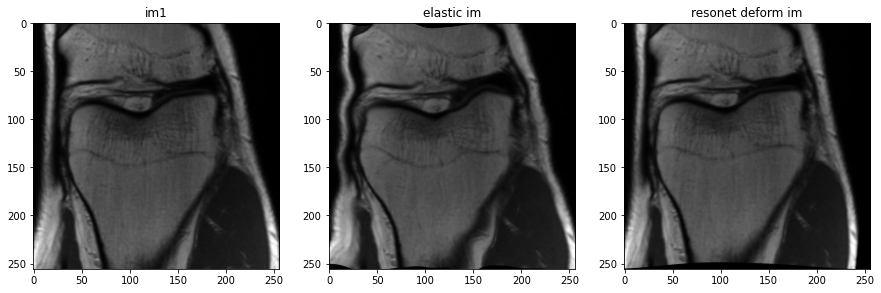

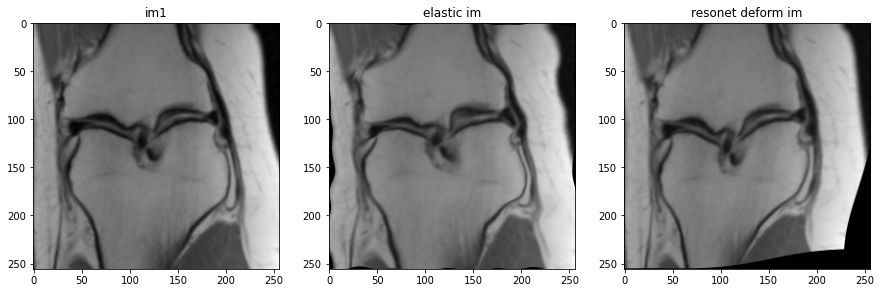

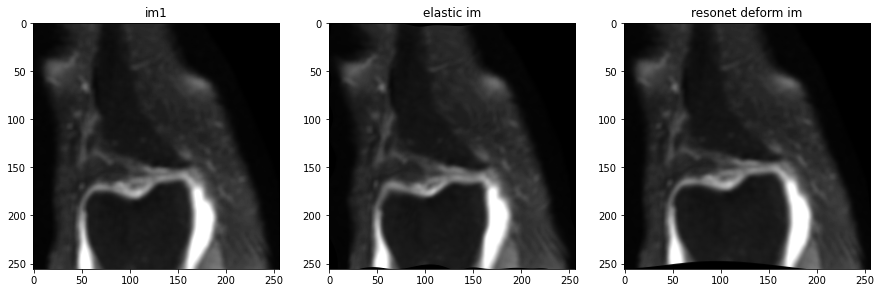

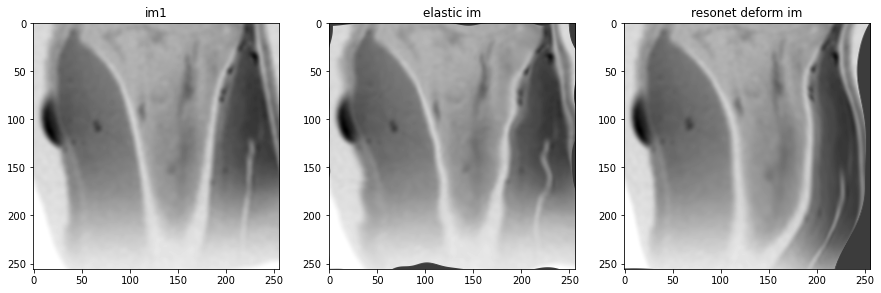

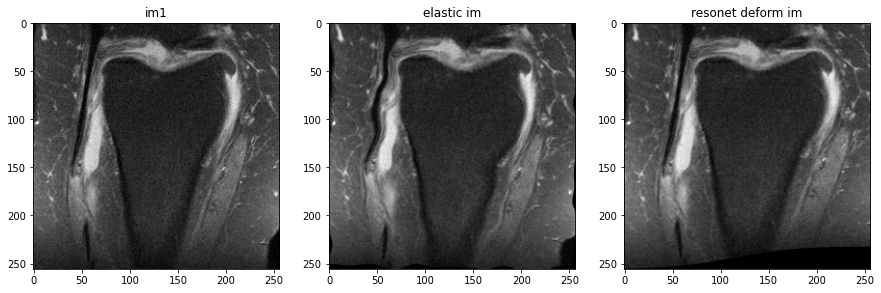

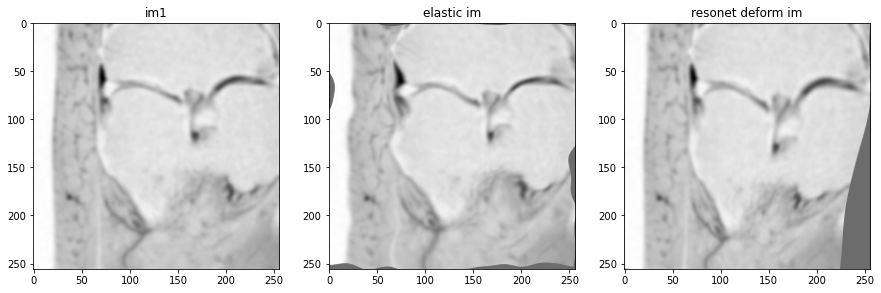

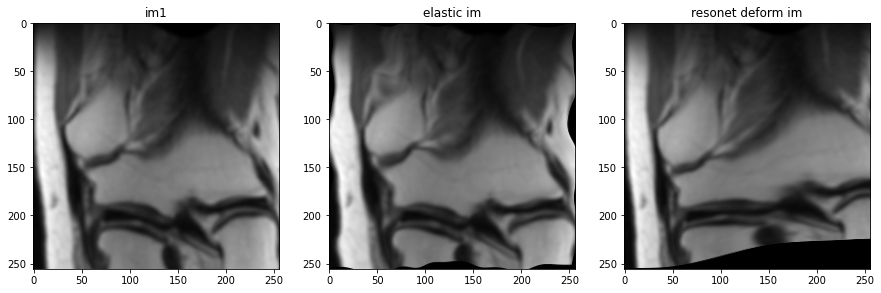

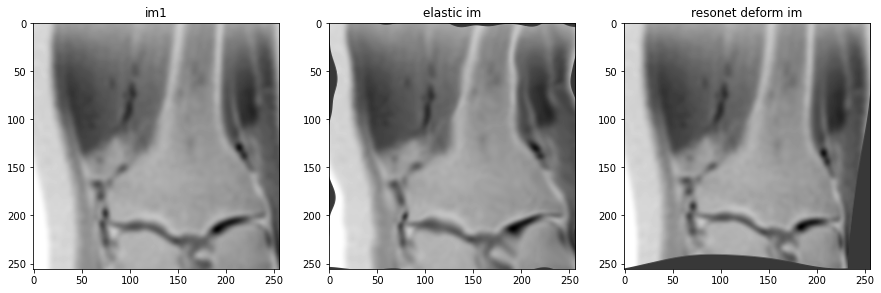

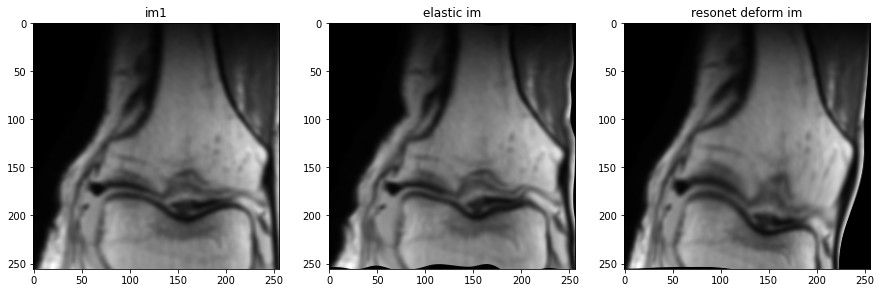

In [156]:
#load example image
datadir = "/mikQNAP/NYU_knee_data/knee_train_h5/data/train"
batchsize = 1
device = torch.device(f'cuda:{3}')

from importlib import reload
import momentum.dataset
reload(momentum.dataset)

magnitude = True

dataset = momentum.dataset.UFData(datadir, magnitude=magnitude, device=device,
                              fastmri=True, random_augmentation=True, normalization=0.99)
dataloader = DataLoader(dataset, batchsize, shuffle=True, drop_last=True,
                                     num_workers=batchsize, pin_memory=True)

for index, im in enumerate(dataloader):
    im1, _ = im
    elastic_im = elastic_deformation(im1)
    maps = random_map(im1.shape)
    resonet_im = resonet_deform(im1, maps)
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.imshow(im1[0,0], cmap='gray')
    plt.title("im1")
    plt.subplot(1,3,2)
    plt.imshow(elastic_im[0,0], cmap='gray')
    plt.title("elastic im")
    plt.subplot(1,3,3)
    plt.imshow(resonet_im[0,0], cmap='gray')
    plt.title("resonet deform im")
    
    if index == 10:
        break

In [154]:
def random_map(shape, kspace_radius_range=(0.001, 0.005)):
        batch_size, c, height, width = shape

        # kspace weight
        x, y = torch.meshgrid(torch.linspace(-0.5, 0.5, height),
                              torch.linspace(-0.5, 0.5, width))
        r = torch.sqrt(x ** 2 + y ** 2)
        kspace_parameter = 1 / torch.FloatTensor(batch_size).uniform_(*kspace_radius_range)

        kspace = 2 * torch.rand(shape, dtype=torch.cfloat) - 1 - 1j  # Channels first
        kspace = kspace * torch.exp(-r.type(torch.cfloat) * kspace_parameter[:, None, None])
        
        maps = ifft2c(kspace)
            
        return maps
    
def resonet_deform(im, maps):
    maps = complex2channels(random_map(im.shape))
    cumsum_deformation_field = torch.cumsum(maps, dim=2)
    cumsum_deformation_field = torch.cumsum(cumsum_deformation_field, dim=3)


    x, y = torch.meshgrid(torch.linspace(-1, 1, 256), torch.linspace(-1, 1, 256))
    x_resample = x[None, None] + cumsum_deformation_field[0] 
    y_resample = y[None, None] + cumsum_deformation_field[1]
    grid = torch.stack((y_resample, x_resample), dim=-1).float()[0]
    deformed_im = F.grid_sample(im, grid)

#     plt.figure(figsize = (10,10))
#     plt.subplot(1,2,1)
#     plt.imshow(x_resample[0,0], cmap='gray')
#     plt.title("map x")
#     plt.subplot(1,2,2)
#     plt.imshow(y_resample[0,0], cmap='gray')
#     plt.title("map y")

#     plt.figure(figsize = (10,10))
#     plt.subplot(1,2,1)
#     plt.imshow(im[0,0], cmap='gray')
#     plt.title("im")
#     plt.subplot(1,2,2)
#     plt.imshow(deformed_im[0,0], cmap='gray')
#     plt.title("deformed im")
    
    return deformed_im

# maps = random_map(im1.shape)
# deformed_im = resonet_deform(im1, maps)

Text(0.5, 1.0, 'deformed im')

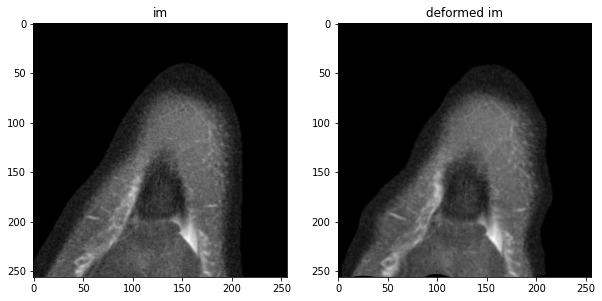

In [149]:
def elastic_deformation(image, intensity=0.8, sigma=10):
    # Generate random deformation field
    deformation_field = torch.randn(2, *image.shape) * intensity

    # Smooth the deformation field using Gaussian filter
    smoothed_deformation_field = torch.from_numpy(gaussian_filter(deformation_field, sigma))
    
    # Calculate the cumulative sum along each dimension to obtain a diffeomorphic deformation
    cumsum_deformation_field = torch.cumsum(smoothed_deformation_field, dim=3)
    cumsum_deformation_field = torch.cumsum(cumsum_deformation_field, dim=4)

    
    x, y = torch.meshgrid(torch.linspace(-1, 1, 256),
                                    torch.linspace(-1, 1, 256))

    grid_output_x = smoothed_deformation_field[0]
    grid_output_y = smoothed_deformation_field[1]

    
    x_resample = x[None, None] + grid_output_x 
    y_resample = y[None, None] + grid_output_y

    
    grid = torch.stack((y_resample, x_resample), dim=-1).float()[0]
        
#     plt.figure(figsize = (10,10))
#     plt.subplot(1,2,1)
#     plt.imshow(grid[0, :, :, 0], cmap='gray')
#     plt.title("map x")
#     plt.subplot(1,2,2)
#     plt.imshow(grid[0, :, :, 1], cmap='gray')
#     plt.title("map y")
                

    deformed_image = F.grid_sample(image, grid)
    
    return deformed_image

elastic_im = elastic_deformation(im1)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(im1[0,0], cmap='gray')
plt.title("im")
plt.subplot(1,2,2)
plt.imshow(elastic_im[0,0], cmap='gray')
plt.title("deformed im")
